# Cosmological Plots for Cosmolunch App

This notebook demonstrates key cosmological quantities using the [CLASS](http://class-code.net/) code. The following plots correspond to figures from *Dodelson, Modern Cosmology* and are intended to help visualize the evolution of the universe.
*These plots will serve as the foundation for the streaming features in the Cosmolunch app.*


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import interpolate
from classy import Class
import matplotlib

In [2]:
cosmo = Class()
ommon_settings = {
    'h': 0.7,
    'omega_b': 0.0224,
    'omega_cdm': 0.1188,
    'n_s': 0.96,
    'sigma8': 0.8,
    'output': 'mPk',
    'P_k_max_1/Mpc': 10.0,
}

---

## 1. Hubble Parameter vs. Redshift  
**(Corresponds to Figure 2.8 in Dodelson)**  
- Plot the Hubble parameter, $H(z)$, as a function of redshift ($0 \leq z \leq 5$).
- Use a linear–log or log–log scale to illustrate how dark energy influences the expansion at late times.

---




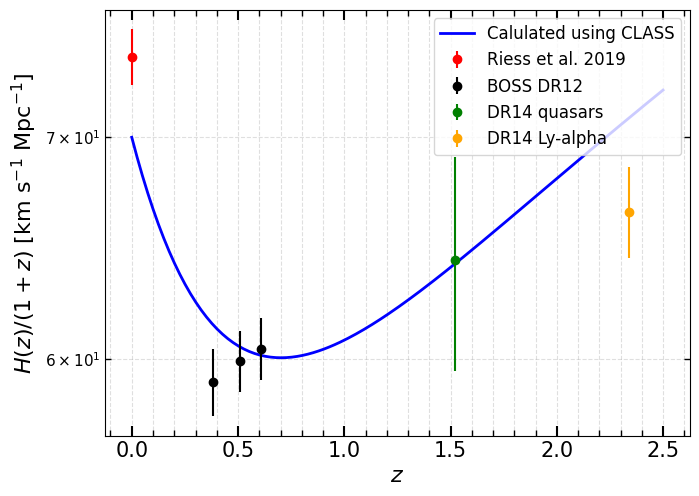

In [3]:
# Set cosmological parameters and compute background
cosmo.set(ommon_settings)
cosmo.compute()
# Data: [z, H(z), error], values from Dodelson
Riess_2019 = np.array([0.0, 74.03, 1.42]) # Riess et al. 2019
BOSS_DR12 = np.array([
    [0.38, 81.5, 1.9],
    [0.51, 90.5, 1.9],
    [0.61, 97.3, 2.1]
]) # BOSS DR12
DR14_quasars = np.array([1.52, 162, 12]) # DR14 quasars
DR14_Ly_alpha = np.array([2.34, 222, 7]) # DR14 Ly-alpha
# Redshift range
z = np.linspace(0, 2.5, 200)
Hz = np.array([cosmo.Hubble(z_i) for z_i in z])  # in Mpc^-1
c_kms = 299_792.458    # km/s
Hz_kmsMpc = Hz* c_kms     

plt.figure(figsize=(7,5))
plt.plot(z, Hz_kmsMpc / (1 + z), color='blue', lw=2, label='Calulated using CLASS')
plt.errorbar(Riess_2019[0], Riess_2019[1] / (1 + Riess_2019[0]), yerr=Riess_2019[2] / (1 + Riess_2019[0]), fmt='o', color='red', label='Riess et al. 2019')
plt.errorbar(BOSS_DR12[:, 0], BOSS_DR12[:, 1] / (1 + BOSS_DR12[:, 0]), yerr=BOSS_DR12[:, 2] / (1 + BOSS_DR12[:, 0]), fmt='o', color='black', label='BOSS DR12')
plt.errorbar(DR14_quasars[0], DR14_quasars[1] / (1 + DR14_quasars[0]), yerr=DR14_quasars[2] / (1 + DR14_quasars[0]), fmt='o', color='green', label='DR14 quasars')
plt.errorbar(DR14_Ly_alpha[0], DR14_Ly_alpha[1] / (1 + DR14_Ly_alpha[0]), yerr=DR14_Ly_alpha[2] / (1 + DR14_Ly_alpha[0]), fmt='o', color='orange', label='DR14 Ly-alpha')
plt.legend(fontsize=12, loc='upper right')
plt.xlabel('Redshift $z$')
plt.ylabel(r'$H(z)/(1+z)$ [km s$^{-1}$ Mpc$^{-1}$]')
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=13, length=7, width=1.5, direction='in', top=True, right=True)
plt.tick_params(axis='both', which='minor', labelsize=11, length=4, width=1, direction='in', top=True, right=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True, which='both', linestyle='--', alpha=0.4)
plt.xlabel('$z$', fontsize=16)
plt.ylabel(r'$H(z)/(1+z)$ [km s$^{-1}$ Mpc$^{-1}$]', fontsize=16)
plt.show()

cosmo.empty()  # free CLASS memory

---

## 2. Distance Measures vs. Redshift  
**(Corresponds to Figure 2.3 in Dodelson)**  
- Overplot the following distance measures as functions of redshift:
    - Comoving distance, $D_C(z)$
    - Angular-diameter distance, $D_A(z)$
    - Luminosity distance, $D_L(z)$

---

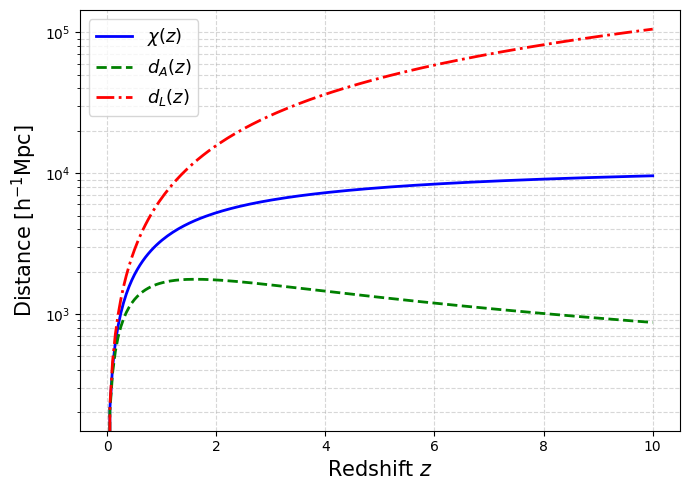

In [4]:
# Set cosmological parameters and compute background (again, if needed)
cosmo.set(ommon_settings)
cosmo.compute()
z = np.linspace(0, 10, 200)  # Redshift range
# Redshift range (reuse z)
chi = np.array([cosmo.angular_distance(z_i) * (1 + z_i) for z_i in z])  # comoving distance, Mpc
d_A = chi / (1 + z)  # angular diameter distance, Mpc
d_L = chi * (1 + z)  # luminosity distance, Mpc

plt.figure(figsize=(7,5))
plt.plot(z, chi, label=r'$\chi(z)$', color='blue', lw=2)
plt.plot(z, d_A, label=r'$d_A(z)$', color='green', lw=2, linestyle='--')
plt.plot(z, d_L, label=r'$d_L(z)$', color='red', lw=2, linestyle='-.')
plt.xlabel('Redshift $z$', fontsize=15)
plt.ylabel(r'Distance [h$^{-1}$Mpc]', fontsize=15)
plt.yscale('log')
#plt.title('Distance Measures vs Redshift', fontsize=16)
plt.legend(fontsize=13, loc='upper left')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

cosmo.empty()

---

## 3. Density Parameter Evolution  
**(Corresponds to Figure 1.3 in Dodelson)**  
- Show the evolution of the density parameters:
    - Matter: $\Omega_m(z)$
    - Dark energy: $\Omega_\Lambda(z)$
    - Radiation: $\Omega_r(z)$
- Highlight the transitions between radiation, matter, and dark energy dominated epochs.

---

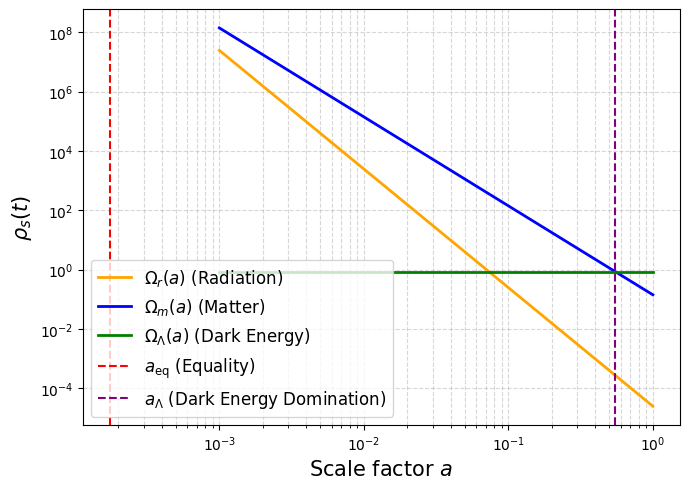

In [5]:
# Calculate density parameters as a function of scale factor a
# Omega_m(a), Omega_r(a), Omega_Lambda(a)

# Cosmological parameters (from ommon_settings)
h = ommon_settings['h']
omega_b = ommon_settings['omega_b']
omega_cdm = ommon_settings['omega_cdm']
omega_m = omega_b + omega_cdm
omega_r = 2.469e-5  # CMB photons, neglecting neutrinos for simplicity
omega_lambda = 1.0 - omega_m - omega_r

# Compute Omega_i(a) = Omega_i0 * a^{-3(1+w)} / E(a)^2
a_plot = np.linspace(1e-3, 1, 100)  # scale factor range

# Physical densities relative to rho_crit,0
rho_r = omega_r * a_plot**(-4)        # radiation ∝ a⁻⁴
rho_m = omega_m * a_plot**(-3)        # matter    ∝ a⁻³
rho_L = omega_lambda * a_plot**(0)          # dark energy ∝ a⁰

# compute equality scale‐factors
a_eq     = omega_r / omega_m
a_lambda = (omega_m / omega_lambda)**(1/3)
plt.figure(figsize=(7,5))
plt.plot(a_plot, rho_r , label=r'$\Omega_r(a)$ (Radiation)', color='orange', lw=2)
plt.plot(a_plot, rho_m , label=r'$\Omega_m(a)$ (Matter)', color='blue', lw=2)
plt.plot(a_plot, rho_L, label=r'$\Omega_\Lambda(a)$ (Dark Energy)', color='green', lw=2)
plt.axvline(a_eq, color='red', linestyle='--', label=r'$a_{\rm eq}$ (Equality)')
plt.axvline(a_lambda, color='purple', linestyle='--', label=r'$a_{\Lambda}$ (Dark Energy Domination)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Scale factor $a$', fontsize=15)
plt.ylabel(r'$\rho_s(t)$', fontsize=15)
#plt.title('Density Parameter Evolution', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

---

## 4. Scale Factor vs. Time  
**(Corresponds to Figure 1.2 in Dodelson)**  
- Convert CLASS’s age output to plot the scale factor $a(t)$ or cosmic time $t(a)$.
- Visualize the history of cosmic expansion.

---

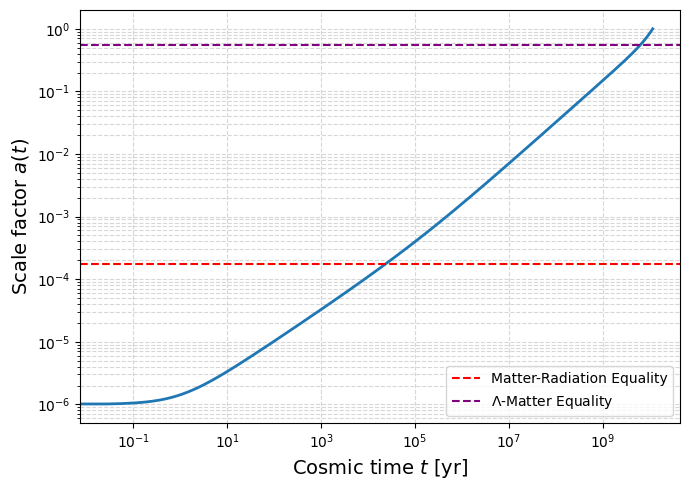

In [6]:
# ——— Scale factor grid ———
a = np.logspace(-6, 0, 1000)  # from 1e-6 to 1
Omega_m = omega_m / (h**2)  # density parameter for matter
Omega_r = omega_r / (h**2)  # density parameter for radiation
Omega_L0 = omega_lambda / (h**2)  # density parameter for dark energy
H0 = 100 * h  # Hubble constant in km/s/Mpc
H0_si = H0 * 1e3 / (3.086e22)  # Hubble constant in s^-1 (Mpc to m conversion)
# ——— Compute E(a) = H(a)/H0 ———
E = np.sqrt(Omega_r/a**4 + Omega_m/a**3 + Omega_L0)

# ——— Numeric integration for t(a) ———
#    dt/da = 1 / [a H(a)] ⇒ t(a) = ∫ da / [a H0 E(a)]
da = np.diff(a)
integrand = 1.0 / (a * H0_si * E)
t = np.concatenate(([0], np.cumsum(0.5*(integrand[:-1] + integrand[1:]) * da)))

# ——— Convert to years ———
seconds_per_year = 3600 * 24 * 365
t_years = t / seconds_per_year

# ——— Compute equality scale factors ———
a_eq = Omega_r / Omega_m  # matter-radiation equality
a_lambda = (Omega_m / Omega_L0) ** (1/3)  # matter-Lambda equality

# ——— Plot a(t) vs t ———
plt.figure(figsize=(7, 5))
plt.loglog(t_years, a, color='C0', lw=2)
plt.axhline(a_eq, color='red', linestyle='--', label=r'Matter-Radiation Equality')
plt.axhline(a_lambda, color='purple', linestyle='--', label=r'$\Lambda$-Matter Equality')
plt.xlabel('Cosmic time $t$ [yr]', fontsize=14)
plt.ylabel('Scale factor $a(t)$', fontsize=14)
#plt.title('Scale Factor vs. Cosmic Time', fontsize=16)
plt.legend()
plt.grid(which='both', ls='--', alpha=0.5)
plt.tight_layout()
plt.show()